In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3" 

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [3]:
from load_data import load_data,class_breakdown

In [4]:
data_name ="EEG"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data EEG
batch size:16
train data (9958, 117, 14),(9958, 1)
test data (4905, 117, 14),(4905, 1)


In [5]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=5466, percentage=54.891
Class=2, total=4492, percentage=45.109
Class=1, total=2675, percentage=54.536
Class=2, total=2230, percentage=45.464


In [6]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (9958, 2)
y test shape: (4905, 2)


## 데이터 정규화

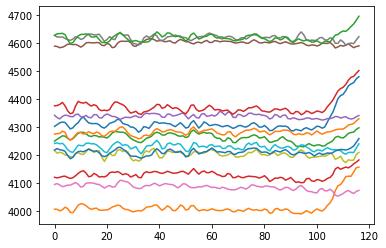

In [7]:
plt.plot(trainx[0])

In [8]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

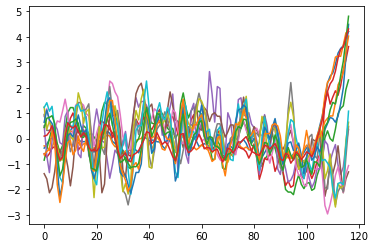

In [9]:
plt.plot(trainx[0])

In [10]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(9958, 1, 117, 14)
trainY shape:(9958, 2)
validX shape:(2452, 1, 117, 14)
validY shape:(2452, 2)
testX shape:(2453, 1, 117, 14)
testY shape:(2453, 2)


In [11]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 117
input_channel 14


# 2. Training condition 정의

In [12]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500

std= 0.01
l_rate = 1e-4

In [13]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [14]:
from FCN import CNN_MC_dropout, CNN_MC_dropout_last_conv_turnoff,CNN_MC_dropout_input_turnoff

In [15]:
import tensorflow as tf

In [16]:
class basic_CNN:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.argmax(self.prediction,1),tf.argmax(self.y,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 64, [1,8], padding='SAME')
            self.pooling1 = tf.layers.max_pooling2d(inputs=self.conv1, pool_size=[1, 4],padding="VALID", strides=2)
            self.batch1 = tf.layers.batch_normalization(self.pooling1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 128, [1,5], padding='SAME')
            self.pooling2 = tf.layers.max_pooling2d(inputs=self.conv2, pool_size=[1, 4] ,padding="VALID", strides=2)                                        
            self.batch2 = tf.layers.batch_normalization(self.pooling2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 256, [1,3], padding='SAME')
            self.pooling3 = tf.layers.max_pooling2d(inputs=self.conv3, pool_size=[1, 4] ,padding="VALID", strides=2)   
            self.batch3 = tf.layers.batch_normalization(self.pooling3)
            self.relu3 = tf.nn.relu(self.batch3)
            self.dropout3 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            self.flatten = tf.reshape(self.relu3, [-1, 12 * 256]) 
            self.dense1 = tf.layers.dense(inputs=self.flatten,
                                     units=128, activation=tf.nn.relu)   
            #Global Average Pooling
            #self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.dense1,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_conv_output(self, conv_output,data, keep_prob,is_dropout):
        conv_output =  self.sess.run((conv_output), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return conv_output
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

In [17]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

2


<font color='red'> turn off 구조는 마지막 convolution layer activation output 에 weight를 elementwise multiply 구조.
train, test시에는 이 weight를 모두 1로 고정하며,
prdiction 시에는 convolution layer activation output에서 상위 T%를 turn off 시키며 accuracy의 변화가 A 이상인 경우를
threshold로 정하기 위해 이러한 모델 구조가 설정되었습니다.</font>

<font color='blue'> CNN_MC_dropout_last_conv_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output을 0으로 turn off 시키는 구조입니다.

반면, <font color='blue'> CNN_MC_dropout_input_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output에 매칭되는(하이라이트 되는 인풋)을 0으로 turn off 시키는 구조입니다.

In [18]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
#MC_dropout_model =CNN_MC_dropout_input_turnoff(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
#                                 std=std,batch_size=batch_size,l_rate=l_rate)

MC_dropout_model =basic_CNN(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

#MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
#                                 std=std,batch_size=batch_size,l_rate=l_rate)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.


In [19]:
print (MC_dropout_model.input)

print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.pooling1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.pooling2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.pooling3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.flatten)
print (MC_dropout_model.dense1)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 117, 14), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 117, 64), dtype=float32)
Tensor("layer1/max_pooling2d/MaxPool:0", shape=(?, 1, 57, 64), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 57, 64), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 57, 64), dtype=float32)
Tensor("layer1/dropout/mul_1:0", shape=(?, 1, 57, 64), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 57, 128), dtype=float32)
Tensor("layer2/max_pooling2d/MaxPool:0", shape=(?, 1, 27, 128), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 27, 128), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 27, 128), dtype=float32)
Tensor("layer2/dropout/mul_1:0", shape=(?, 1, 27, 128), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 27, 256), dtype=float32)
Tensor("layer3/max_pooling2d/MaxPool:0", shape=(?, 1, 12, 25

# 4. Training

In [20]:
import time
import os
import numpy as np

In [21]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_basic_standardized_dropout_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16


In [22]:
from training import get_batch

In [23]:
keep_prob =0.5

In [24]:
# for epoch in range(num_epochs):#range(num_epochs):##
    
#     loss = 0
#     acc=0
#     train_batches = 0
#     start_time = time.time()   
    
#     for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
#         train_in, train_target = batch
#         train_batches += 1.0 
#         loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
#         loss = loss1+loss
#         acc = acc1+acc
#         if np.isnan(loss):
#             print ('error')
#             break
#     t_loss.append(loss/train_batches)
#     t_acc.append(acc/train_batches)
    
#     train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
#     if not os.path.exists(os.path.join(save_path, model_name)):
#         os.mkdir( os.path.join(save_path, model_name))
#     MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
#     if(epoch+1)%val_freq ==0:
#         acc=0
#         loss = 0
#         val_batches=0
#         for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
#             val_in, val_target = batch
#             val_batches += 1.0 
#             loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
#             loss = loss1+loss
#             acc = acc1+acc
        
#         v_acc.append(acc/val_batches)
#         v_loss.append(loss/val_batches)
#         valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
#         print("  training loss:\t{:.6f}".format(t_loss[epoch]))
#         print("  training acc:\t{:.3f}".format(t_acc[epoch]))
#         print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
#         print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


In [25]:
# train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
# valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [26]:
from visualization import plot_train_history

In [27]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/loss_graph.png
save ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/acc_graph.png


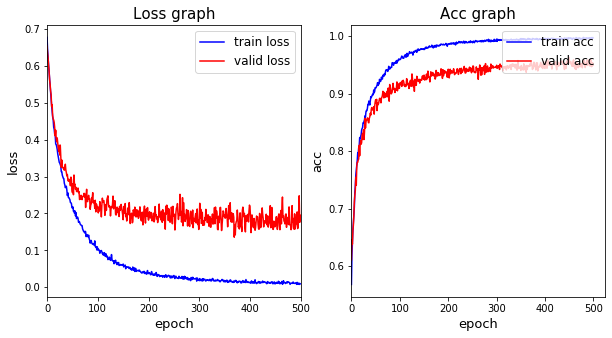

In [28]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [29]:
bestepoch = int(np.argmin(valid_history['loss'].values))
print( bestepoch)

369


In [30]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.13569027635526998


In [31]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/369.ckpt
Model restored


In [32]:
import glob
for epoch in [x+1 for x in range(num_epochs) if (x+1) !=bestepoch]:
    for filename in glob.glob(os.path.join(save_path,model_name,str(epoch)+".*")):
        os.remove(filename) 

### with confusion matrix

In [33]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [34]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

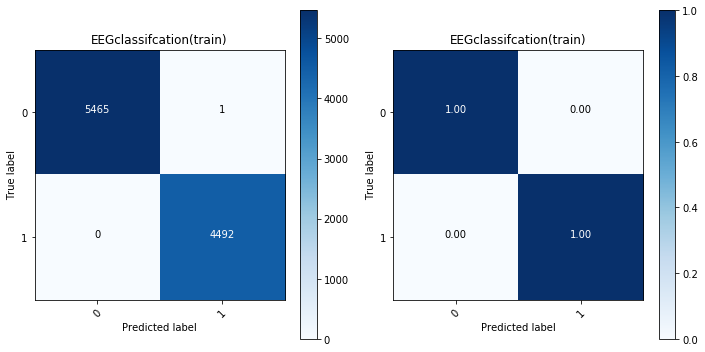

In [35]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

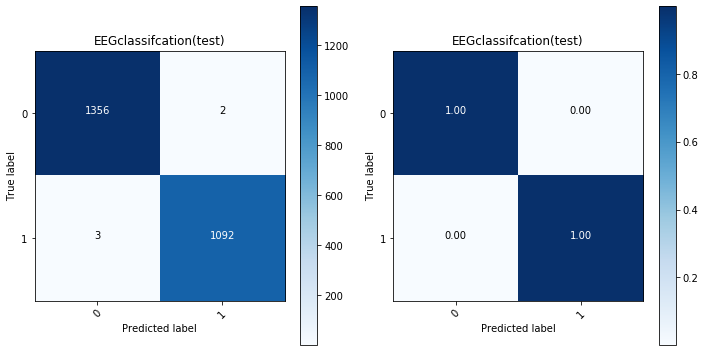

In [36]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# 6. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)
기존논문에서 이미지타겟으로 p(A>T)=0.005 인것과 비교하여, 시계열에서는 조금 더 낮은 threshold가 패턴을 보기에 필요함.
acc를 ~이상 떨어지게 하는 threshold

In [37]:
import random

In [38]:
original_acc = MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.is_dropout:False})

In [39]:
conv_output1 = MC_dropout_model.get_conv_output(conv_output = MC_dropout_model.relu1,data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
conv_output2 = MC_dropout_model.get_conv_output(conv_output = MC_dropout_model.relu2,data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
conv_output3 = MC_dropout_model.get_conv_output(conv_output = MC_dropout_model.relu3,data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]

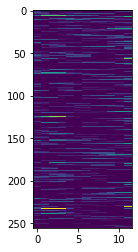

In [90]:
ax = plt.subplot(1,3,3)
ax.imshow(conv_output3[0].T,aspect='auto')

## unit 에 적용할 threshold를 정하고, 각 conv에서 unit끼리의 IOU 수치 구하기

<font color='red'> threshold를 정할 때, 해당 T% 이상인 last convolution activation output을 turnoff 시킬때의 accuracy 변화가 A이상일 때를 기준으로 합니다 </font>

In [40]:
A=5

threshold는 우선 임시로 상위 5%로 정해놓았습니다

In [41]:
threshold1 = np.percentile((conv_output1.flatten()),100 - A)
threshold2 = np.percentile((conv_output2.flatten()),100 - A)
threshold3 = np.percentile((conv_output3.flatten()),100 - A)

In [42]:
conv_bool1 = conv_output1 > threshold1
conv_bool2 = conv_output2 > threshold2
conv_bool3 = conv_output3 > threshold3

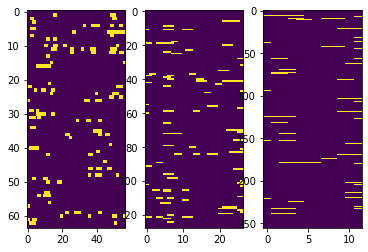

In [43]:
ax = plt.subplot(1,3,1)
ax.imshow(conv_bool1[3].T,aspect='auto')
ax = plt.subplot(1,3,2)
ax.imshow(conv_bool2[0].T,aspect='auto')
ax = plt.subplot(1,3,3)
ax.imshow(conv_bool3[0].T,aspect='auto')

### Network Dissetion Code

for x, index in enumerate(top[unit]):
    row = x // gridwidth
    col = x % gridwidth
    image = imread(ds.filename(index))
    mask = imresize(features[index][unit], image.shape[:2], mode='F')
    mask = mask > thresholds[unit]
    vis = (mask[:, :, numpy.newaxis] * 0.8 + 0.2) * image
    if vis.shape[:2] != (imsize, imsize):
        vis = imresize(vis, (imsize, imsize))
    tiled[row*(imsize+gap):row*(imsize+gap)+imsize,
          col*(imsize+gap):col*(imsize+gap)+imsize,:] = vis

In [44]:
def upsampling(y, target_len):
    newx = np.arange(0, target_len)
    tempx = np.linspace(0, target_len, len(y))
    newy = np.interp(newx, tempx, y)
    return newy

In [45]:
conv_output3_extend= np.zeros((500, 117, 256))
for d_idx in range(500):
    for c_idx  in range(256):
        conv_output3_extend[d_idx, :, c_idx] = upsampling(conv_output3[d_idx, :, c_idx], 117)

In [46]:
conv_bool3_extend = conv_output3_extend > threshold3

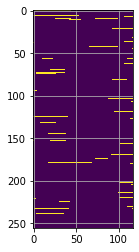

In [47]:
plt.imshow(conv_bool3_extend[0].T)
plt.grid()
plt.show()

In [48]:
def mask_upsampling(mask, target_len):
    p_len = np.array([0,9,9,9,10,10,10,10,10,10,10,10,10])
    new_mask = np.zeros((target_len, mask.shape[1]))
    for m in range(mask.shape[1]):
        for i in range(mask.shape[0]):
            new_mask[np.cumsum(p_len)[i]:np.cumsum(p_len)[i+1] ,m]=mask[i,m] 
    return new_mask

In [49]:
conv_bool3_extend_mask= np.zeros((500, 117, 256))
for d_idx in range(500):
    conv_bool3_extend_mask[d_idx] = (mask_upsampling(conv_bool3[d_idx], 117) > 0 )

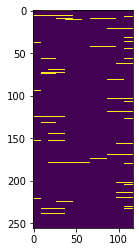

In [50]:
plt.imshow(conv_bool3_extend_mask[0].T)
plt.show()

## 패턴 추출

In [51]:
import itertools
from itertools import groupby

In [52]:
input_channel =0 
pattern_length = 9
consecutive_pattern=[]
step_size = 8

pattern_id = 0
for data_idx,data in enumerate(trainX[:500,:,:,[input_channel]]):
    for output_channel_idx in range(256):
        highlight_idx = [p for p, x in enumerate(conv_bool3_extend_mask[data_idx][:,output_channel_idx]) if x]
        if highlight_idx:
            groups = []
            for _, g in groupby(highlight_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=pattern_length:
                    for start_idx in range(0,len(g)-pattern_length+1,step_size):
                        short_pattern_idx = [g[x] for x in range(start_idx, start_idx+pattern_length)]
                        consecutive_pattern.append({"data_idx":data_idx, "pattern_id":pattern_id,
                                                    "pattern_xs":short_pattern_idx, "pattern_ys":data[0,short_pattern_idx].flatten(), 
                                                    "input_channel":input_channel,"output_channel":output_channel_idx})
                        pattern_id +=1    
# Save as npy
np.save('consecutive_pattern2.npy', consecutive_pattern) 

In [53]:
#Load
consecutive_pattern = np.load('consecutive_pattern2.npy',allow_pickle='TRUE')

In [54]:
consecutive_pattern[0]

{'data_idx': 0,
 'pattern_id': 0,
 'pattern_xs': [9, 10, 11, 12, 13, 14, 15, 16, 17],
 'pattern_ys': array([-0.02978407,  0.31404666,  0.486091  ,  0.19513746, -0.05635163,
        -0.10922883, -0.12238364, -0.10922883, -0.22813803]),
 'input_channel': 0,
 'output_channel': 0}

In [55]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform([x['pattern_ys'] for x in consecutive_pattern])
normalized_pattern_candidate = normalized_pattern_candidate.squeeze()
normalized_pattern_candidate.shape

(80863, 9)

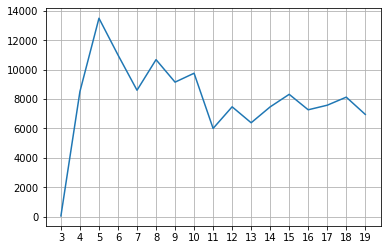

In [56]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import cluster, mixture

pseudoF_gmm = []

cut_num=20
for n_clusters in range(3,cut_num):
    gmm = mixture.GaussianMixture(n_components=n_clusters, 
            covariance_type='full').fit(normalized_pattern_candidate)
    labels = gmm.predict(normalized_pattern_candidate)
    pseudoF_gmm.append(metrics.calinski_harabasz_score(normalized_pattern_candidate, labels))

x = np.arange(3,cut_num)
plt.plot(x, pseudoF_gmm[:cut_num])
plt.xticks(x)
plt.grid()
plt.show()

In [57]:
# pseudoF_kmeans = []

# cut_num=20
# for n_clusters in range(3,cut_num):
#     kmeans_model = cluster.KMeans(n_clusters=n_clusters, random_state=1).fit(normalized_pattern_candidate)
#     labels = kmeans_model.labels_
#     pseudoF_kmeans.append(metrics.calinski_harabasz_score(normalized_pattern_candidate, labels))

# x = np.arange(3,cut_num)
# plt.plot(x, pseudoF_kmeans[:cut_num])
# plt.xticks(x)
# plt.grid()
# plt.show()

In [61]:
best_g_clusters = 5
best_k_clusters = 5

In [62]:
#n_cluster : interger
#eigen_solver{None, ‘arpack’, ‘lobpcg’, or ‘amg’}
#affinity: ‘nearest_neighbors’‘rbf’

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

random.seed(300)

default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}
default_hac = {'method':'single','metric':'euclidean','cut_off_level':5,'criterion':'maxclust'}

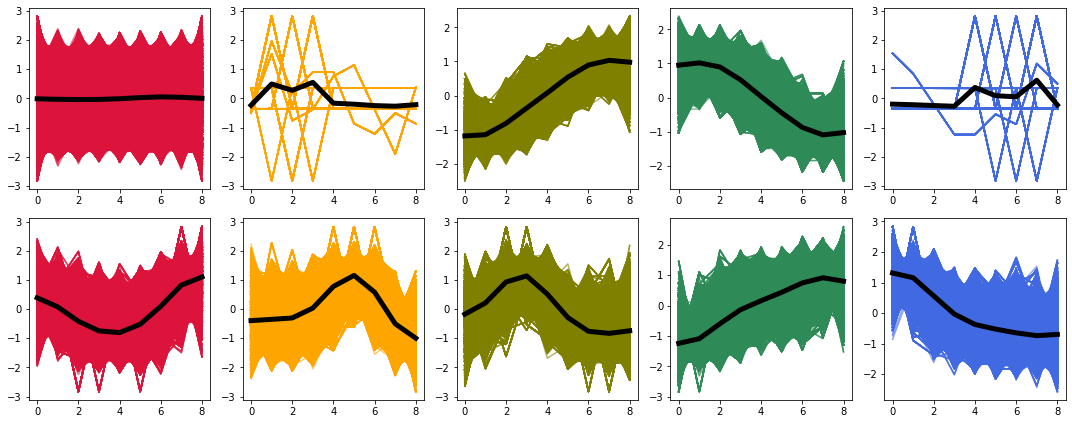

In [63]:
g_cluster_pattern_list = []
k_cluster_pattern_list = []

gmm_option = [
    ({'n_clusters': best_g_clusters})
]

kmeans_option = [
    ({'n_clusters': best_k_clusters})
]

for g_option,k_option in zip(gmm_option,kmeans_option):
    g_params = default_gmm.copy()
    g_params.update(g_option)

    k_params = default_kmeans.copy()
    k_params.update(k_option)

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])

    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,6))
    axes = fig.subplots(2, g_params['n_clusters'])

    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        
        g_class_pattern = np.array([normalized_pattern_candidate[idx] for idx in g_class_idx])
        k_class_pattern = np.array([normalized_pattern_candidate[idx] for idx in k_class_idx])

        g_cluster_mean = g_class_pattern.mean(axis=0)
        k_cluster_mean = k_class_pattern.mean(axis=0)

        # visualization
        axes[0,class_].plot(g_class_pattern.T, color =color[class_],alpha=0.6)
        axes[1,class_].plot(k_class_pattern.T, color =color[class_],alpha=0.6)

        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)
        
        # append list
        g_cluster_pattern_list.extend([{"class":class_,"pattern_id":idx,"pattern_ys":normalized_pattern_candidate[idx],"pattern_mean":g_cluster_mean} for idx in g_class_idx])
        k_cluster_pattern_list.extend([{"class":class_,"pattern_id":idx,"pattern_ys":normalized_pattern_candidate[idx],"pattern_mean":k_cluster_mean} for idx in k_class_idx])
 

    #("KMeans: {} \nGMM: {}".format(k_params,g_params),y=1.5)
    plt.tight_layout()
    plt.show()

### Removing Outlier

In [64]:
from dtwalign import dtw

/home/sohee/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


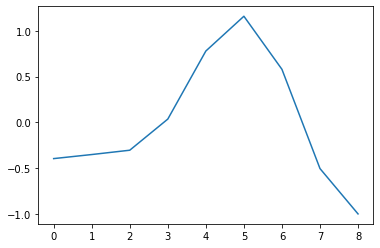

In [81]:
class_num = 1
k_class_pattern = [{"pattern_id":x["pattern_id"],"pattern_ys":x["pattern_ys"],"pattern_mean":x["pattern_mean"],"k_id":i} for i,x in enumerate(k_cluster_pattern_list) if x["class"] == class_num]
k_cluster_mean = k_class_pattern[0]["pattern_mean"]
plt.plot(k_cluster_mean)

In [66]:
WSS=[{"pattern_id":x["pattern_id"], "dtw_score": dtw(x["pattern_ys"], k_cluster_mean).normalized_distance,"pattern_ys":x["pattern_ys"]} for x in k_class_pattern]

In [67]:
WBS_idx = np.argsort([x['dtw_score'] for i, x in enumerate(WSS)])

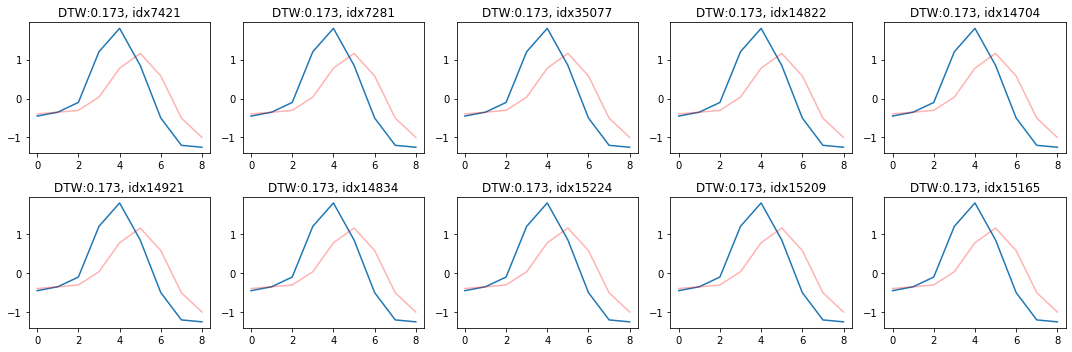

In [68]:
display_num = 10
fig, axes = plt.subplots(display_num//5,5,figsize=(15,display_num//2))

for i in range(display_num):
    a = i // 5
    b = i % 5

    axes[a,b].plot(WSS[WBS_idx[i]]['pattern_ys'])
    axes[a,b].plot(k_cluster_mean,color='r',alpha=0.3)
    axes[a,b].set_title("DTW:"+str(format(WSS[WBS_idx[i]]['dtw_score'],".3f"))+", idx"+str(WSS[WBS_idx[i]]['pattern_id']))

plt.tight_layout()
plt.show()

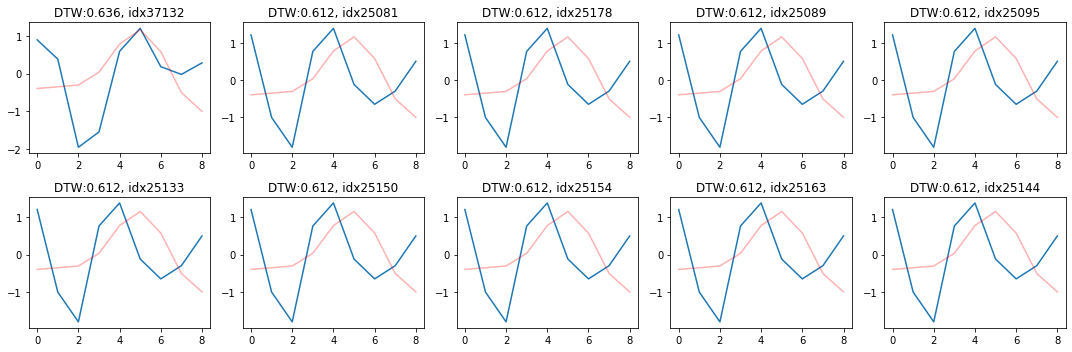

In [69]:
display_num = 10
fig, axes = plt.subplots(display_num//5,5,figsize=(15,display_num//2))

for i in range(display_num):
    a = i // 5
    b = i % 5
    axes[a,b].plot(WSS[WBS_idx[::-1][i]]['pattern_ys'])
    axes[a,b].plot(k_cluster_mean,color='r',alpha=0.3)
    axes[a,b].set_title("DTW:"+str(format(WSS[WBS_idx[::-1][i]]['dtw_score'],".3f"))+", idx"+str(WSS[WBS_idx[::-1][i]]['pattern_id']))

plt.tight_layout()
plt.show()

## DTW score가 크면 그룹에서 제외

In [70]:
dtw_score = 0.4

In [71]:
k_dtw_idx = [i for i, x in enumerate(k_cluster_pattern_list) if dtw(x["pattern_ys"], x["pattern_mean"]).normalized_distance < dtw_score]
k_cluster_pattern_dtw = [x for i, x in enumerate(k_cluster_pattern_list) if i in k_dtw_idx]

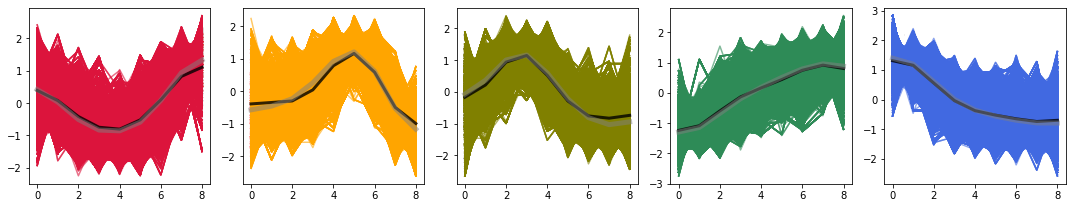

In [72]:
fig = plt.figure(figsize=(len(np.unique(g_pred))*3,3))
axes = fig.subplots(1, g_params['n_clusters'])

for class_ in range(0,g_params['n_clusters']):
    k_class_pattern = np.array([x['pattern_ys'] for x in k_cluster_pattern_dtw if x['class']==class_])
    k_cluster_mean = [x['pattern_mean'] for x in k_cluster_pattern_dtw if x['class']==class_][0]
    k_cluster_mean_new = k_class_pattern.mean(axis=0)

    # visualization
    axes[class_].plot(k_class_pattern.T, color =color[class_],alpha=0.6)
    axes[class_].plot(k_cluster_mean, color ='black',alpha=0.8,linewidth=3)
    axes[class_].plot(k_cluster_mean_new, color ='grey',alpha=0.5,linewidth=5)

#("KMeans: {} \nGMM: {}".format(k_params,g_params),y=1.5)
plt.tight_layout()
plt.show()

In [73]:
dtw_score = 0.3

In [74]:
k_dtw_idx = [i for i, x in enumerate(k_cluster_pattern_list) if dtw(x["pattern_ys"], x["pattern_mean"]).normalized_distance < dtw_score]
k_cluster_pattern_dtw = [x for i, x in enumerate(k_cluster_pattern_list) if i in k_dtw_idx]

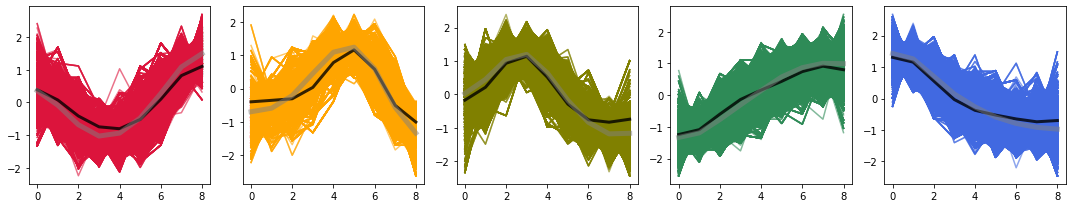

In [75]:
fig = plt.figure(figsize=(len(np.unique(g_pred))*3,3))
axes = fig.subplots(1, g_params['n_clusters'])

for class_ in range(0,g_params['n_clusters']):
    k_class_pattern = np.array([x['pattern_ys'] for x in k_cluster_pattern_dtw if x['class']==class_])
    k_cluster_mean = [x['pattern_mean'] for x in k_cluster_pattern_dtw if x['class']==class_][0]
    k_cluster_mean_new = k_class_pattern.mean(axis=0)

    # visualization
    axes[class_].plot(k_class_pattern.T, color =color[class_],alpha=0.6)
    axes[class_].plot(k_cluster_mean, color ='black',alpha=0.8,linewidth=3)
    axes[class_].plot(k_cluster_mean_new, color ='grey',alpha=0.5,linewidth=5)

#("KMeans: {} \nGMM: {}".format(k_params,g_params),y=1.5)
plt.tight_layout()
plt.show()

### INPUT에 투영

In [76]:
import more_itertools as mit
from sklearn.preprocessing import MinMaxScaler

In [79]:
[x["pattern_id"] for x in specific_pattern_info if x["output_channel"] == out_ch]

[106, 107]

In [88]:
consecutive_pattern[106]

{'data_idx': 1,
 'pattern_id': 106,
 'pattern_xs': [77, 78, 79, 80, 81, 82, 83, 84, 85],
 'pattern_ys': array([ 0.96535055,  1.03211434,  1.09887814, -0.10941565, -1.45123702,
        -1.5860737 , -1.38447323, -1.98927466, -2.25763894]),
 'input_channel': 0,
 'output_channel': 0}

In [113]:
k_cluster_pattern_list[61778]

{'class': 4,
 'pattern_id': 106,
 'pattern_ys': array([ 1.22770029,  1.27903621,  1.33037213,  0.40129258, -0.63045882,
        -0.73413726, -0.5791229 , -1.04416597, -1.25051625]),
 'pattern_mean': array([ 1.31081295,  1.15726795,  0.55838258, -0.03347739, -0.37483428,
        -0.52683835, -0.64990449, -0.7407834 , -0.70062558])}

In [94]:
k_cluster_id_list = [x["pattern_id"] for x in k_cluster_pattern_list]

In [112]:
k_cluster_id_list.index(106)

61778

In [101]:
k_cluster_id_list

[8,
 18,
 57,
 116,
 119,
 135,
 137,
 167,
 174,
 180,
 196,
 205,
 217,
 219,
 223,
 225,
 227,
 229,
 232,
 235,
 239,
 241,
 250,
 252,
 255,
 260,
 264,
 270,
 272,
 274,
 277,
 281,
 283,
 286,
 288,
 294,
 296,
 299,
 303,
 307,
 309,
 311,
 313,
 316,
 319,
 325,
 327,
 330,
 332,
 335,
 337,
 340,
 342,
 347,
 352,
 357,
 360,
 363,
 366,
 368,
 370,
 372,
 374,
 382,
 390,
 392,
 397,
 400,
 402,
 404,
 407,
 411,
 414,
 419,
 421,
 424,
 426,
 428,
 430,
 432,
 436,
 438,
 439,
 445,
 448,
 450,
 451,
 457,
 461,
 462,
 464,
 465,
 466,
 470,
 471,
 478,
 479,
 483,
 484,
 490,
 491,
 495,
 500,
 506,
 507,
 513,
 518,
 520,
 521,
 522,
 524,
 528,
 533,
 534,
 538,
 540,
 545,
 547,
 549,
 555,
 558,
 560,
 561,
 562,
 566,
 567,
 570,
 571,
 577,
 578,
 581,
 583,
 586,
 592,
 593,
 597,
 598,
 603,
 604,
 608,
 609,
 610,
 616,
 621,
 627,
 631,
 634,
 645,
 658,
 661,
 684,
 687,
 690,
 692,
 694,
 701,
 719,
 724,
 732,
 737,
 746,
 754,
 768,
 770,
 779,
 783,
 788,
 7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


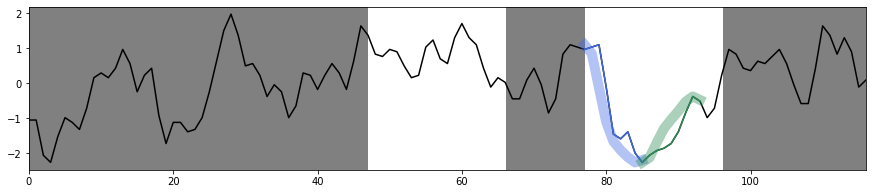

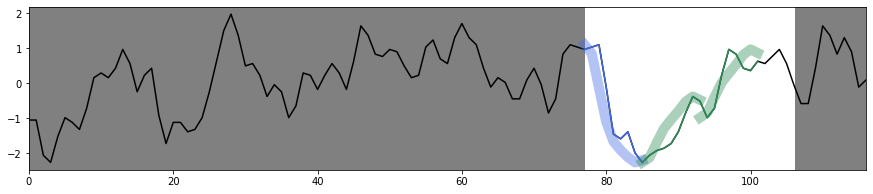

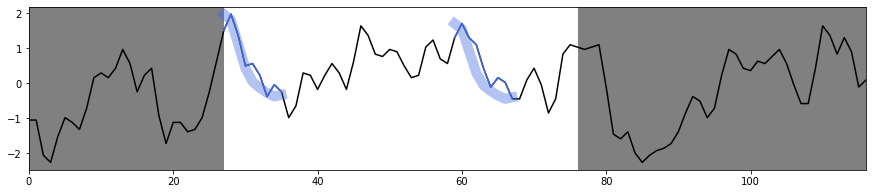

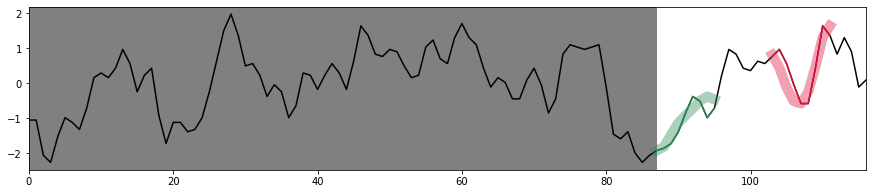

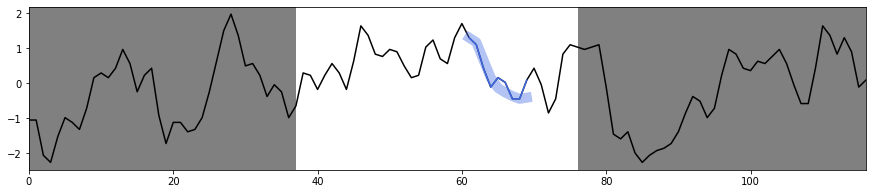

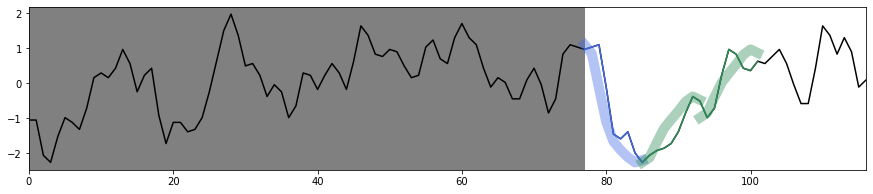

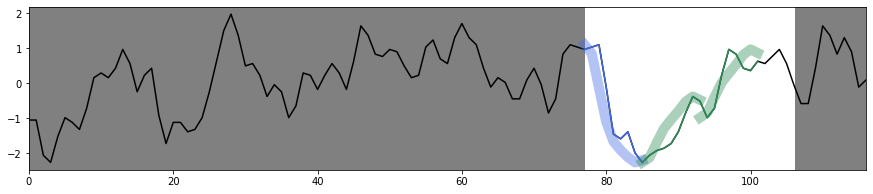

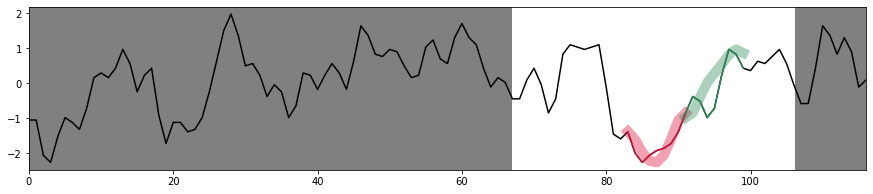

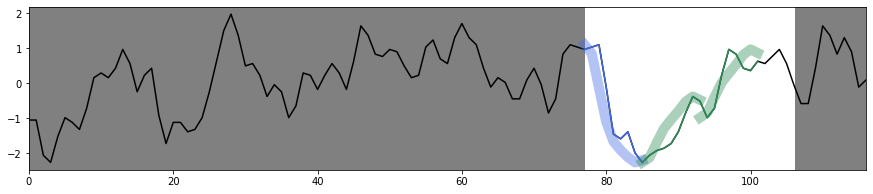

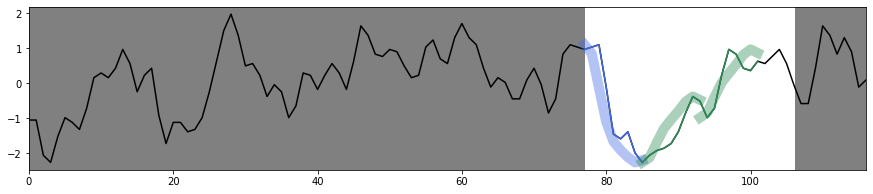

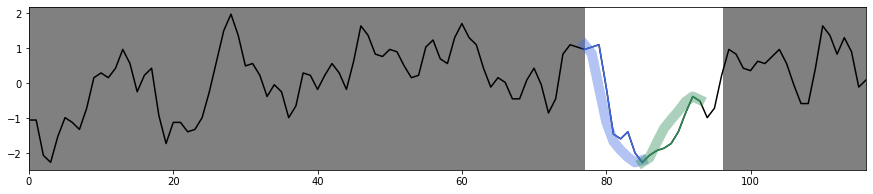

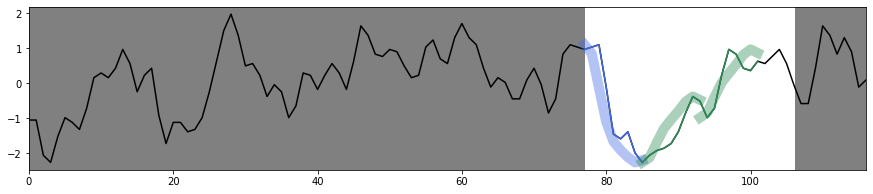

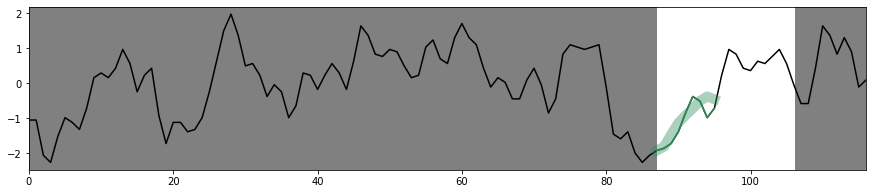

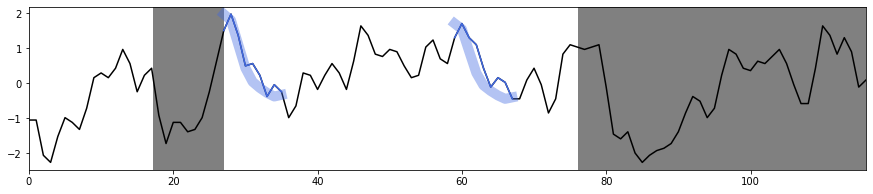

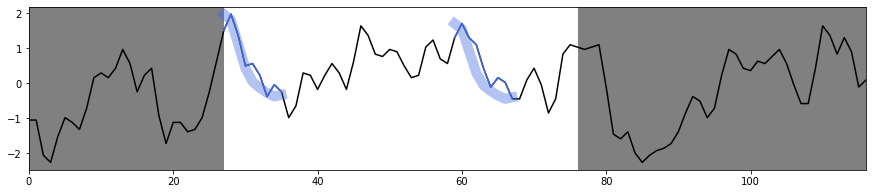

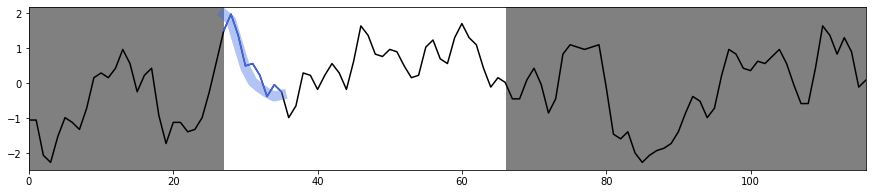

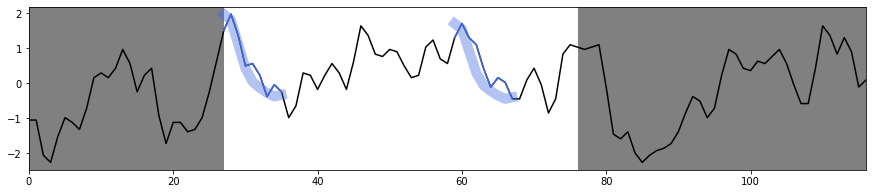

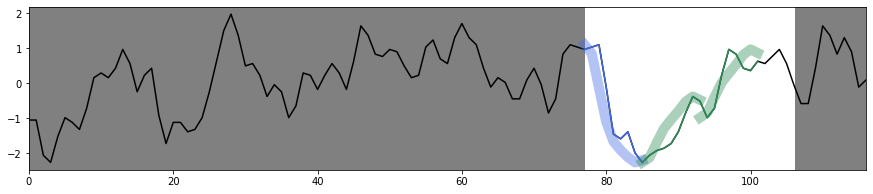

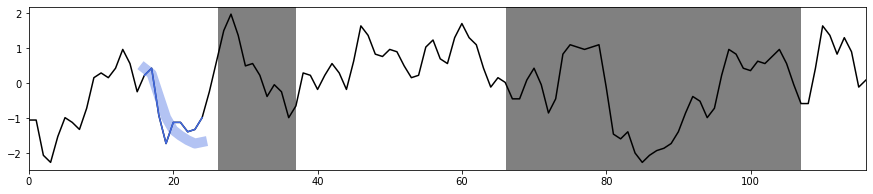

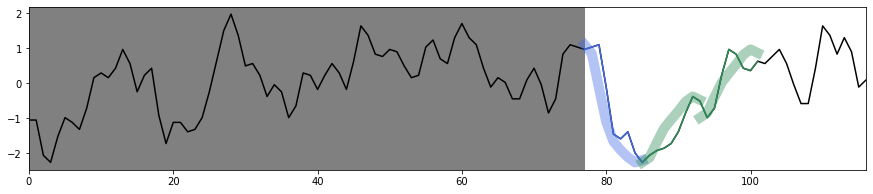

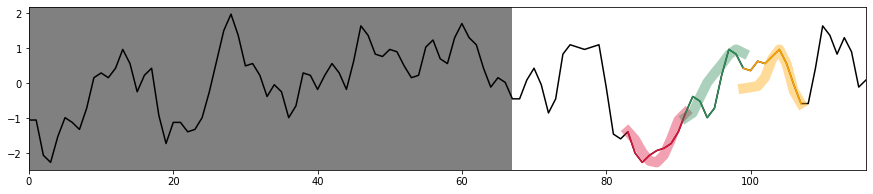

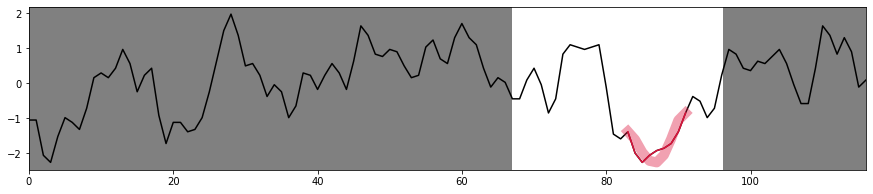

In [115]:
plot_idx = 0
sample_data_idx = [1]

k_cluster_id_list = [x["pattern_id"] for x in k_cluster_pattern_list]
for d_idx in sample_data_idx:

    k_survive_pattenrn_idx = [x['pattern_id'] for x in k_cluster_pattern_dtw] # d번째 데이터에서 k_mean dtw값이 0.2이하인 패턴들
    ######## 특정 샘플의 패턴 리스트 생성  
    specific_data_pattern_idx = [i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_idx = list(set(specific_data_pattern_idx) & set(k_survive_pattenrn_idx))
    specific_pattern_info = [consecutive_pattern[i] for i in specific_pattern_idx]

    specific_pattern_ch_idx = np.unique([(x['output_channel']) for x in specific_pattern_info])
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==10:
        break
    
    for out_ch in specific_pattern_ch_idx:
        # 데이터 자체 그리기
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        
        #하이라이트 그리기 
        ax.set_facecolor("grey")
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(conv_bool3_extend_mask[d_idx,:,out_ch]) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
        

        pattern_idxs = [x["pattern_id"] for x in specific_pattern_info if x["output_channel"] == out_ch]
        for idx in pattern_idxs:
            # 패턴
            xs = consecutive_pattern[idx]["pattern_xs"]   
            clusterd_pattern = k_cluster_pattern_list[k_cluster_id_list.index(idx)]
            color_idx = clusterd_pattern["class"]
            ax.plot(xs, data[xs], color = color[color_idx])
        
            # 패턴평균값 
            mean = np.array(clusterd_pattern["pattern_mean"]).reshape(-1,1)
            min_max_scaler = MinMaxScaler(feature_range=(data[xs].min(), data[xs].max()))
            pattern_scaled = min_max_scaler.fit_transform(mean)
            ax.plot(xs, pattern_scaled, color = color[color_idx], alpha=0.4,linewidth=10)

        #fig.suptitle("data{} : label{}, prediction{} \n in last conv output_channel{}".format(d_idx, np.argmax(trainY[d_idx]),np.argmax(prediction[d_idx]),p_info['pattern_channel']),y=1.0)
    plt.show()
    

In [ ]:
convs_pattern=[]
stride_size=2
pooling_size=4
for data_idx,data in enumerate(trainX[:500,:,:,:]):
    for conv_idx in range(3,4):
        conv_bool = eval("conv_bool"+str(conv_idx))
        for conv_channel in range(conv_bool.shape[2]):
            pattern_highlight_idx = [p for p,x in enumerate(conv_bool[data_idx,:,conv_channel]) if x]
            input_highlight_idx=[np.arange(stride_size*p, (stride_size*p)+pow(pooling_size,conv_idx)) for p in pattern_highlight_idx]
            input_highlight_idx_extend=np.sort(list(set(np.asarray(input_highlight_idx).flatten())))
            groups=[]
            for _, g in groupby(input_highlight_idx_extend, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                for data_channel in range(input_channel):
                    convs_pattern.append({"data_idx":data_idx,"input_channel": data_channel,
                                          "conv_idx":conv_idx,"conv_channel": conv_channel,
                                          "input_highlight_idx":input_highlight_idx,"input_highlight_idx_extend":input_highlight_idx_extend,
                                          "upscaled_pattern_idx":g,  "pattern":data[0,g,data_channel].flatten()})

conv 끼리 모으려면 아래의 코드를 돌리시면 됩니다.

In [ ]:
conv1_pattern = [x for x in convs_pattern if x['conv_channel']==1]
conv2_pattern = [x for x in convs_pattern if x['conv_channel']==2]
conv3_pattern = [x for x in convs_pattern if x['conv_channel']==3]

In [ ]:
len([x for x in convs_pattern if (x['data_idx']==0)])